<a href="https://colab.research.google.com/github/lillianpoland/hi-class/blob/main/LillPolaU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

##Calories


This project will analyze the ways in which different biological factors affect the number of calories one burns during exercise. Calories are a measure of energy that we need to survive-to support regular bodily functions like breathing and heart and brain function. We consume calories by eating and drinking. Calories that aren't used by our bodies through regular operation or through exercise are stored as fat, motivating people to exercise in order to burn excess calories. The total number of calories a person burns in a day is known as Total Daily Energy Expenditure, which is composed of calories burned at rest, calores burned to digest food, and calories burned during physical activity (what we will be focusing on). We will be analyzing the main factors that affect calorie expenditure to determine which ones play the biggest role.

In [ ]:
calories = pd.read_csv('https://raw.githubusercontent.com/lillianpoland/hi-class/refs/heads/main/calories%20data.csv')

In [ ]:
calories

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190,94,29,105,40.8,231
1,female,20,166,60,14,94,40.3,66
2,male,69,179,71,13,100,40.5,71
3,female,34,179,71,13,100,40.5,71
4,female,27,154,58,10,81,39.8,35
5,female,36,151,50,23,96,40.7,123
6,female,33,158,56,22,95,40.5,112
7,male,41,175,85,25,100,40.7,143
8,male,60,186,94,21,97,40.4,134
9,female,26,146,51,16,90,40.2,72


##Variable Selection

Variable selection will help determmine which of the following factors are most important in predicting calorie burn. Selecting only the most important factors will avoid overfitting, as irrelevant or redundant variables will lead to overfitting (where the model will perform well on training data but poorly on new data).

The burning of calories is affected by MANY factors, including ones that were not included in the data set. In the process of doing this project, I made 2 causal diagrams, one including many outside variables, and the other relying on the variables given from the data. The original causal diagram included age, weight, height, duration of exercise, heart rate, body temp, and gender (the included variables) along with exersize type, sleep, diet, and overall fitness level. These outside variables contributed mainly to the duration of exercise and heart rate. However, the inclusion of these variables created redundance. So, the inclusion of only the provided variables is the best option. I chose to exclude gender because, while Men and Women have different BMIs, gender does not have as strong a relationship with calorie expenditure as the other variables provided. Going into this selection I knew duration and heart rate would be very important, as the outside variables I came up with all directly related to those 2 variables, which gave me some insight in this selection process.

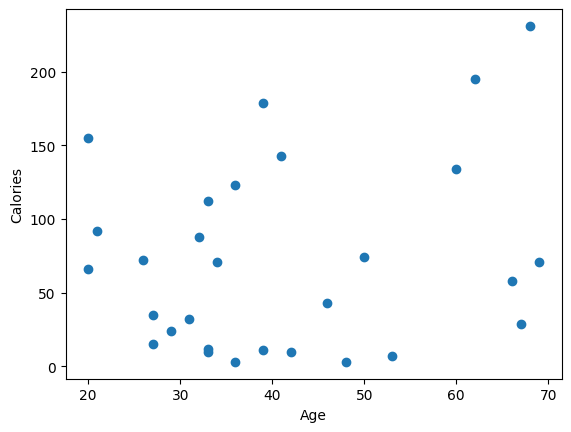

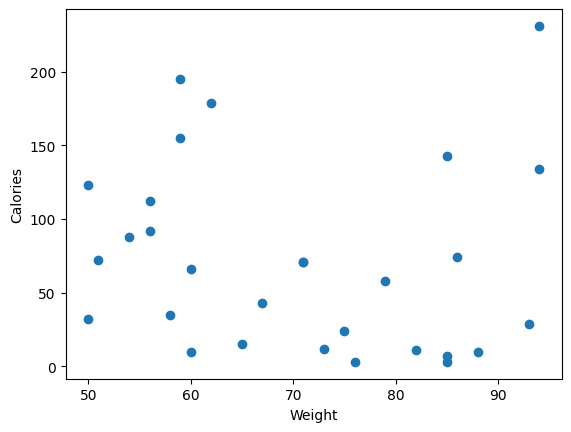

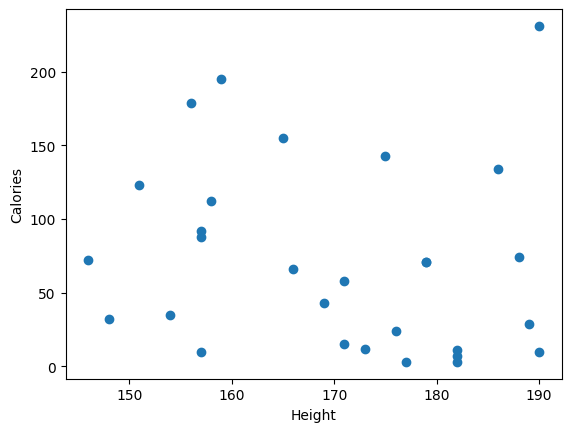

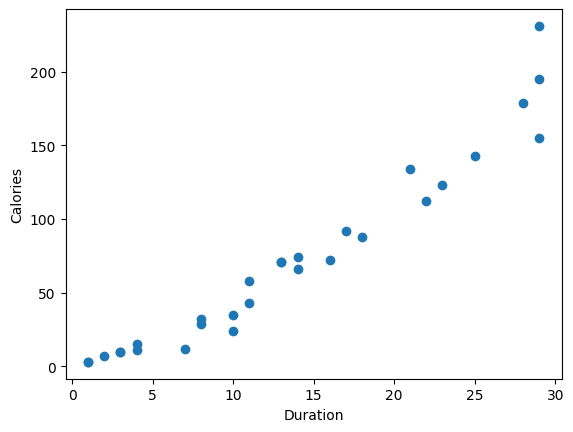

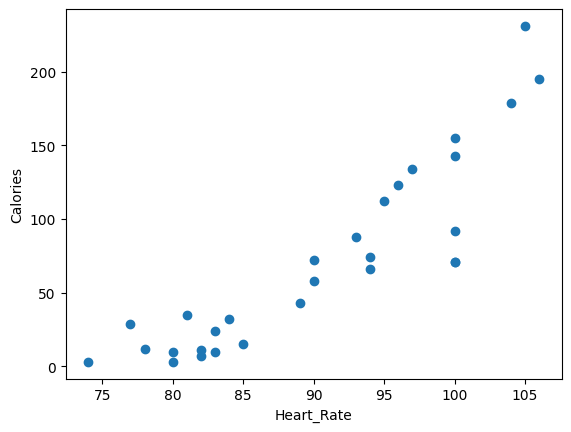

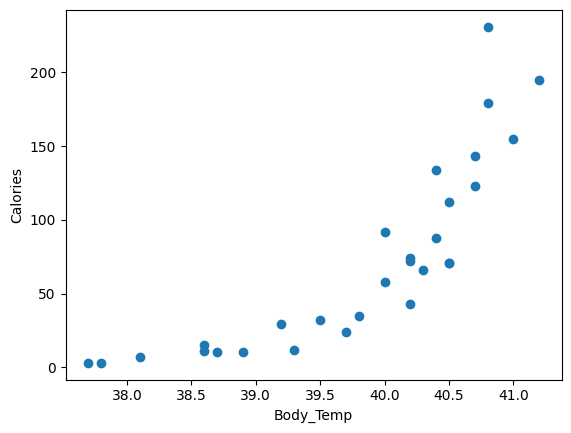

In [ ]:
x = ["Age", "Weight", "Height", "Duration", "Heart_Rate", "Body_Temp"]
y = "Calories"
for a in x:
  plt.scatter(calories[a], calories[y])
  plt.xlabel(a)
  plt.ylabel(y)
  plt.show()

These scatter plots illustrate which variables directly relate to the burning of calories. While age, weight, and height play a role, they do not show the same causal relationship through a clearly defined pattern. This indicates that, while age, weight, and height may impact heart rate and other variables that affect calorie-burn, they do not provide as clear a connection to calorie burn. On the other hand, duration, heart rate, and body temp show a causal relationship with the calories burned based on the clear pattern in the scatter plots. This supports a common sense understanding and context of calorie burn. Duration makes sense, as the longer you exercise, the more calories you burn. This is a direct and straightforward relationship. Heart rate is not as obvious in my opinion, but a higher heart rate generally indicates a higher intensity of effort. As the heart beats faster, it pumps more blood to muscles, fueling them and leading to increased calorie burning. Body temperature also makes sense, as your body temp rises due to increased activity. This temperature rise comes along with the calorie burning, and you continue to burn calories when your body works to cool itself down through sweating. This relationship tells us that exercise intensity (shown from heart rate and body temp) and duration are key to a higher calorie burn. Understanding these relationships helps determine which variables to prioritize and focus on in our models. Knowing these relationships can also help you make decisions about your exercise routine! If you want to burn a ton of calories, you might opt for a longer workout session that will elevate your heart rate more.

## model selection

Now we will select which model to use to analyze our data. I am choosing to compare a negative binomial model and mutiple linear model using elpd_loo (LOO). A negative binomial model uses a single predictor variable. We will use duration, as it had the most clear relationship with calorie burning. The multiple linear model incorporates two predictor variables, and we will use duration and heart rate. The negative binomial is better than say, a poisson distrubition because it allows for more variability in the calorie counts. However, it is simpler than the multiple linear model.

In [ ]:
!pip install bambi

In [ ]:
import bambi as bmb

In [ ]:
#nbb stands for negative binomial calorie model
with pm.Model() as model_nbc:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * calories.Duration))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=calories.Calories)

    #we need the log likelihood for model comparison later
    idata_nbc = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_nbc, model = model_nbc, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
#mlc stands for multiple linear calories
with pm.Model() as model_mlc:

    #priors on the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)

    #linear part of the model
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * calories.Heart_Rate + β1 * calories.Duration))

    #prior for the standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=calories.Calories)

    #we need the log likelihood for model comparison later
    idata_mlc = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.sample_posterior_predictive(idata_mlc, model = model_mlc, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
az.loo(idata_mlc)

,0
elpd_loo,-127.375077
se,5.474789
p_loo,3.393417
n_samples,2000
n_data_points,29
warning,False
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


In [ ]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"multi_lin":idata_mlc,"single_lin":idata_nbc} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-127.375077,3.393417,0.000000,1.0,5.474789,0.000000,False,log
single_lin,1,-158.322194,1.827372,30.947118,0.0,4.834963,3.059784,False,log


This chart gives a very clear comparison of the multi and single models. We want whichever model has a more positive value, in this case the multi_lin model. This indicates better predictive accuracy. We can see that the warning is false for both, which is good as it means the K diagnostic was good enough. Plotting this chart will help us to better visualize the comparison.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

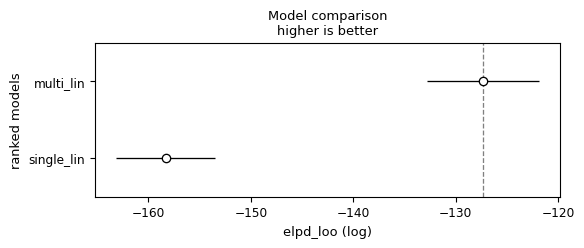

In [ ]:
az.plot_compare(cmp_df)

The plotted Loo graph visually represents the compairson between the two models. The X axis shows the difference in ELPD and which one is more positive (the multi_lin). The horizontal lines represent the standard errors of the ELPD differences. The longer the line is, the greater the uncertainity is in the estimate. The vertical line represents the ELPD of the best ranked model (Multi_lin). Models away from this aren't as good. The chart gives us the information we need, but the graph makes it very clear visually which model will be better.

##Final model

Now that we know which variable to use, we can use bambi to help us create our final model. This final model will put together the most important chosen variables and show the relationships. Bambi is much better for generalized linear models because they are more concise and easier to understand. Bambi is also better because you don't need huge blocks of code to create plots for linear models (yay!!). Another good thing is that bambi models impose constraints that prevent overfitting!

In [ ]:
!pip install bambi

In [ ]:
#have to drop incomplete rows, so that bambi will run
calories = pd.read_csv('https://raw.githubusercontent.com/lillianpoland/hi-class/refs/heads/main/calories%20data.csv')

In [ ]:
#filter out the combo positions. This will make it easier to read the graphs
calories = calories.query("Gender in ['male','female']")

In [ ]:
#define the model
model_calories = bmb.Model("`Calories` ~ `Duration` + `Heart_Rate`", data=calories)
#fit the model
idata_calories = model_calories.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Duration', ylabel='Calories'>], dtype=object))

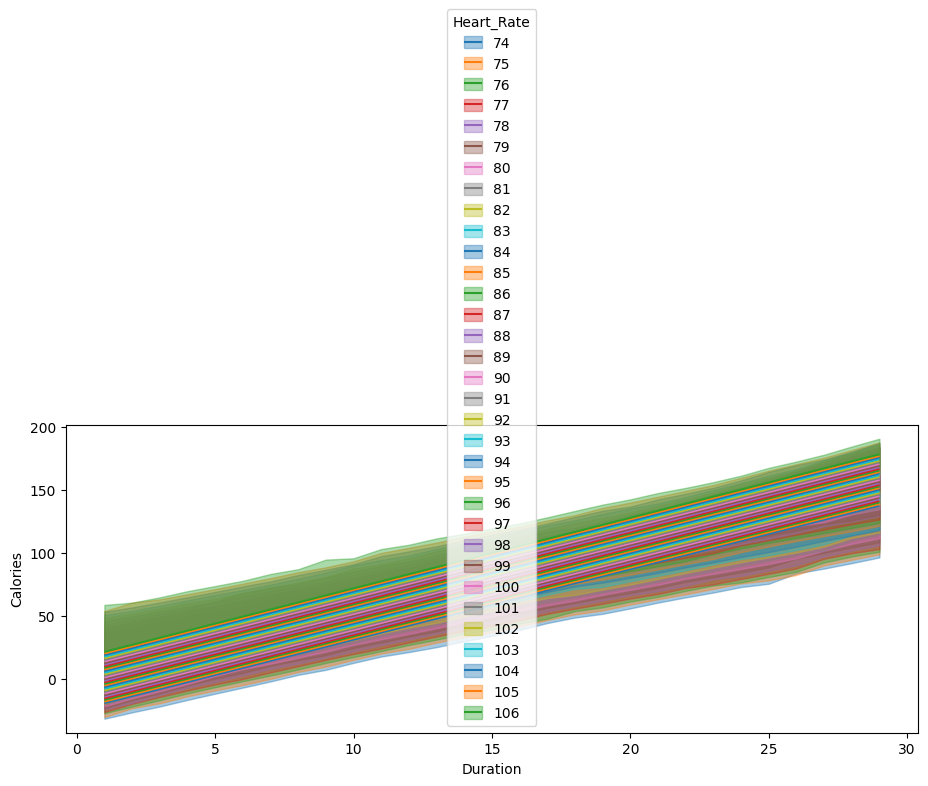

In [ ]:
#plot 94% HDIs of the means of each position
bmb.interpret.plot_predictions(model_calories,
                               idata_calories,
                                ["Duration",  "Heart_Rate"], fig_kwargs={"figsize":(11, 4)})

This graph shows exactly what we expected. It visualizes the calories burned based on duration and heart rate, the two variables we have marked as most influential. The graph clearly demonstrates a positive relationship between both duration and heart rate with calories burned. As either of the variables increase, the calories burned also increases. The steepness of the slope would indicate a certain type of effect on calories burned (either less or more), so duration likely has a steeper slope and would have a greater influence on calories than heart rate.

In [ ]:
#define the model; cal_interq stands for calorie interaction quantiative
model_cal_interq = bmb.Model("`Calories` ~ `Duration` + `Weight` + `Duration`:`Weight`", data=calories)
#create the model
idata_cal_interq = model_cal_interq.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


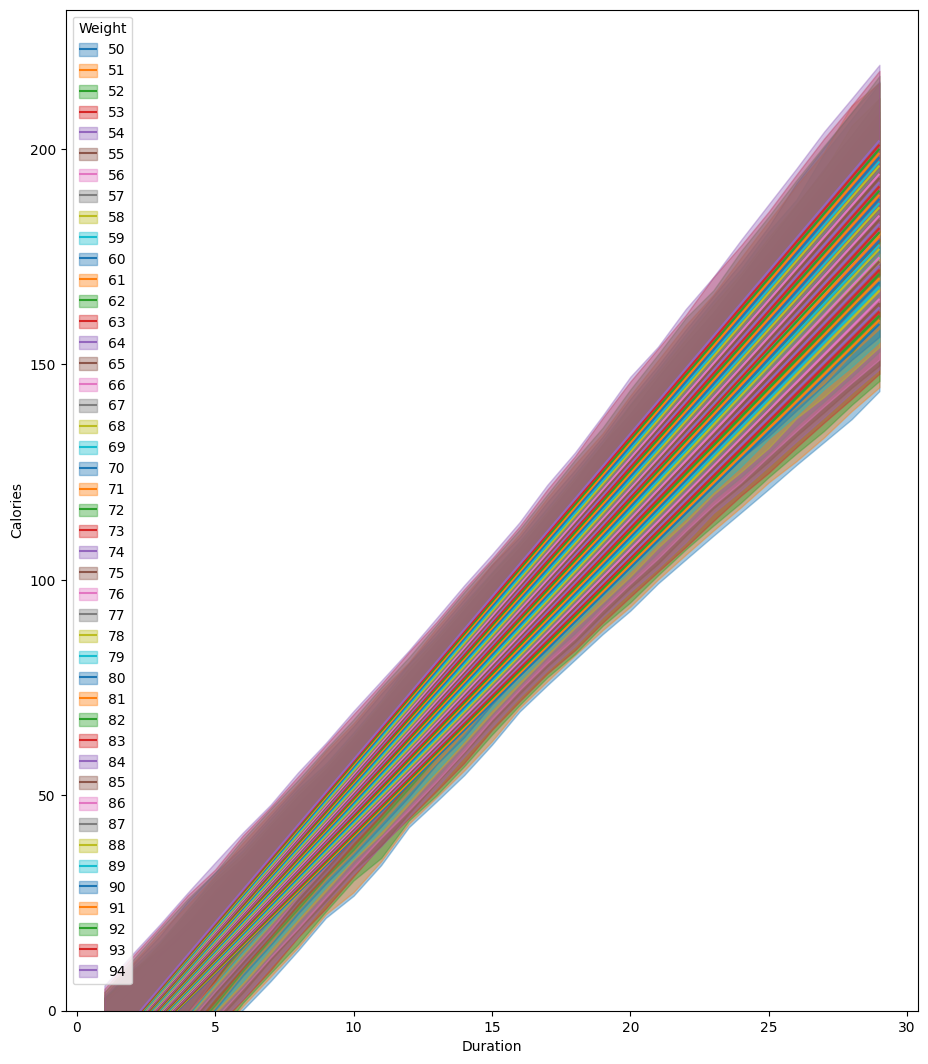

In [ ]:
bmb.interpret.plot_predictions(model_cal_interq,
                               idata_cal_interq,
                               ["Duration","Weight"],
                               fig_kwargs={"figsize":(11, 13)})#,
                               #legend=False)
# Your plotting code here (e.g., plt.scatter(), plt.plot(), etc.)

# Set the y-axis limits
plt.ylim(0)  # Set the minimum limit to 0, maximum is automatically adjusted

plt.show()  # Display the plot with the adjusted y-axis

This final graph visualizes the calories burned based on duration and weight. I decided to create this becuase I know that weight affects heart rate, so I wanted to see if this relationship would remain true, even though the scatter plots make it unclear if weight has a true direct impact on calories burned. The lines are not exactly parallel, so we can assume that the effect of duration on calories burned changes depending on your weight. This makes sense, as  a 300 lb person going on a run will burn more calories than a 100 lb person. The varying slopes can tell us the same message, showing the effects of duration of exersise for different weights. For heavier people, this line might be steeper, meaning longer exercising leads to more calories burned compared to lighter people.

##Conclusion

Both graphs give important information regarding the factors that influence calories burned during exercise. However, I think that graph 2 is better in this scenario. Even though our scatter plots made it seem like weight did not have as large an impact on calories burned, I used my own knowledge and context to assess this. Graph 2 has a better relevance to the real world, as stated in the summary of the graph above (when a larger person runs, they burn more calories than a lighter person). This graph also allows us to view a deeper understanding of the dynamics of these variables, beyond just the straight-forward options. Both graphs are important, as graph 1 shows the relationship between 2 very direct variables on calorie burning, but the 2nd graph provides a better overall analysis.